In [32]:
# imports stolen from Rony
# Essentials
import datetime
import requests
import json
import pandas as pd
import numpy as np
import re
import umap

# Math
import scipy as sc
import statsmodels.api as sm

# Gensim
import gensim
import gensim.downloader as model_api

# SKLearn
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import sklearn.feature_extraction.text as text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score

# Plots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [3]:
# using wikipedia model for embeddings
word_vectors = model_api.load("glove-wiki-gigaword-50")

In [4]:
"""
Use DF from saved CSV:
"""
df = pd.read_csv('data.csv')

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
196,3.0,0.172900,0.350178,-0.0572,-0.028600,0.00000,0.287950,0.5759
1star,1.0,0.793500,NaN,0.7935,0.793500,0.79350,0.793500,0.7935
2020PoliceBrutality,2.0,0.047800,1.052741,-0.6966,-0.324400,0.04780,0.420000,0.7922
2ALiberals,5.0,-0.123160,0.862388,-0.9265,-0.757900,-0.54230,0.690800,0.9201
600euro,1.0,-0.599400,NaN,-0.5994,-0.599400,-0.59940,-0.599400,-0.5994
...,...,...,...,...,...,...,...,...
worldnews,140.0,-0.036009,0.552850,-0.9669,-0.557725,0.00000,0.451325,0.9252
worldpolitics,16.0,-0.171313,0.548423,-0.8122,-0.719075,-0.27225,0.346025,0.6705
yesyesyesno,1.0,-0.984000,NaN,-0.9840,-0.984000,-0.98400,-0.984000,-0.9840


In [5]:
#tf-idf dictionary for looking up tf-idf
tf = text.TfidfVectorizer()
tf.fit_transform(df.body)
tfidf_dict = dict(zip(tf.get_feature_names(), tf.idf_))

In [6]:
# for tokenization
replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",
})

rep = dict((re.escape(k), v) for k, v in replaceDict.items())
pattern = re.compile("|".join(rep.keys()))

def replacer(text):
    return rep[re.escape(text.group(0))]

# word tokens
words = df.body.str.replace(pattern, replacer).str.lower().str.split()
words = pd.DataFrame(words.tolist())

In [7]:
# for embeddings (with tf-idf weighting)
def soft_get(w):
    try:
        return word_vectors[w] * tfidf_dict[w] 
    except KeyError:
        return np.zeros(word_vectors.vector_size)

def map_vectors(row):
    try:
        res = row.loc[row.notna()].apply(soft_get)
        if len(res) > 0:
            return np.sum(
                res
            )
        else:
            return np.zeros(word_vectors.vector_size)
    except:
        return np.zeros(word_vectors.vector_size)

In [8]:
# embeddings
emb = pd.DataFrame(words.apply(map_vectors, axis=1).tolist())


In [9]:
emb

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,324.169569,-101.782881,188.590556,-84.696749,262.275249,160.882470,-311.378786,-194.384120,-48.628200,159.774591,...,-188.728664,-39.988268,71.084246,473.220528,-69.528677,51.071113,-252.809517,165.019333,12.190725,61.201488
1,1.106997,6.253315,3.048972,1.378207,8.011830,-1.007316,-11.342033,-4.026970,-6.877193,-5.419635,...,-10.553662,4.730996,2.753592,-1.710049,-5.708594,4.159546,-11.739000,-0.052593,-7.089589,2.194988
2,-6.812750,9.589057,-6.019777,-7.875253,4.966043,7.151505,-2.698799,-7.119408,1.238317,-18.853733,...,0.942210,-5.130002,0.097944,14.543777,-19.744577,-2.451993,1.447870,-1.632108,-1.867629,-1.044971
3,122.058351,-25.711241,65.703602,-207.985881,229.093374,145.728715,-58.771860,-41.433156,-36.325161,119.985943,...,-129.363199,19.798607,16.019744,231.908823,45.742656,-21.307367,-97.845796,67.251839,25.241530,162.877010
4,8.898841,3.604885,8.894474,-14.624264,17.459316,4.134914,-20.403711,-2.213972,-12.621965,4.830530,...,-10.746164,-1.462586,-2.168203,16.897449,-9.938808,-5.654969,-2.772371,1.506884,0.394545,-6.957738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35577,264.239313,-97.252327,48.823210,-166.927460,41.743011,67.405608,-211.125175,-65.769656,-29.033189,16.234087,...,-201.473313,27.884586,124.467971,109.163401,48.689891,70.198853,-185.194521,90.804615,-29.651733,-25.750422
35578,-4.427136,6.714112,0.069211,-1.108533,7.424747,2.260036,-3.313583,1.771700,-3.455736,6.617154,...,-6.119874,-0.123229,-13.110659,1.653922,3.078819,-2.451417,0.140745,-12.751160,3.302285,6.767509
35579,-11.662728,-2.534237,3.099111,11.374338,-0.492726,-11.424948,11.229380,-3.248935,-4.462661,7.733011,...,11.325293,-4.416806,-3.384961,9.309134,-1.933874,9.201985,2.673530,11.582323,10.452363,5.567337
35580,12.635550,6.309694,13.600769,-2.537620,26.506162,-8.798683,-31.040129,-13.191412,-9.968165,-10.890798,...,-26.726221,0.589330,9.888681,-2.993265,-11.604129,21.910075,-34.773906,18.766183,-5.144761,14.246242


In [26]:
# normalize embedding matrix row-wise
emb_norm = emb.div(emb.sum(axis=1), axis=0)
emb_norm = emb_norm.dropna()

reducer = umap.UMAP(metric='cosine') # n_neighbors=10, , min_dist=0.01
emb_umap = reducer.fit_transform(emb_norm)

(35579, 2)

For n_clusters = 2 The average silhouette_score is : 0.44770348
For n_clusters = 4 The average silhouette_score is : 0.7949112
For n_clusters = 8 The average silhouette_score is : 0.59647715


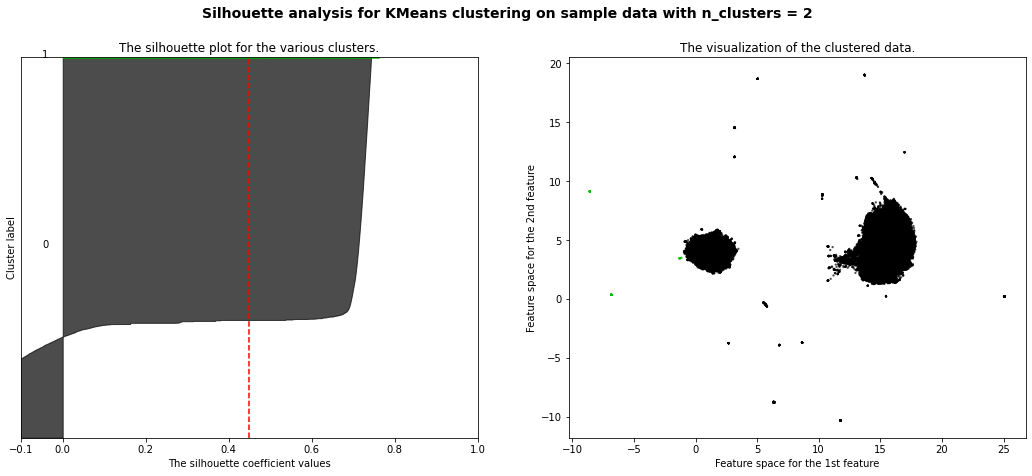

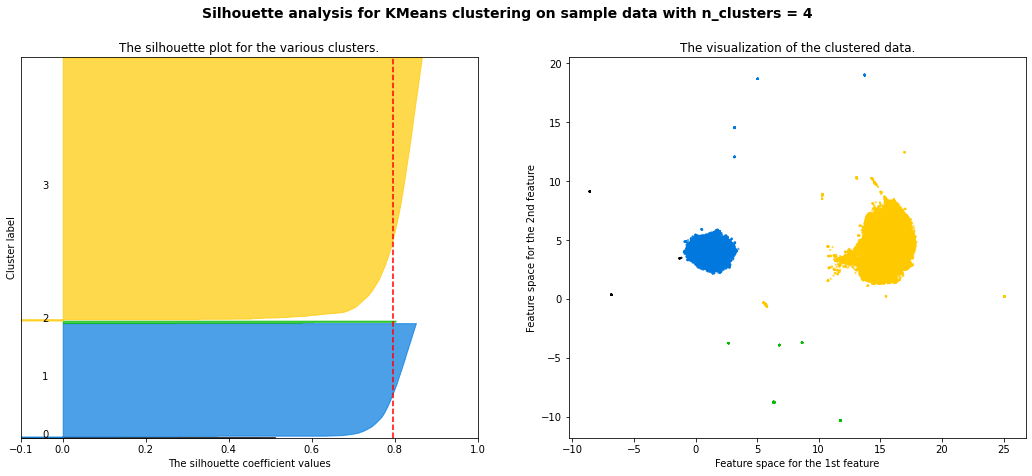

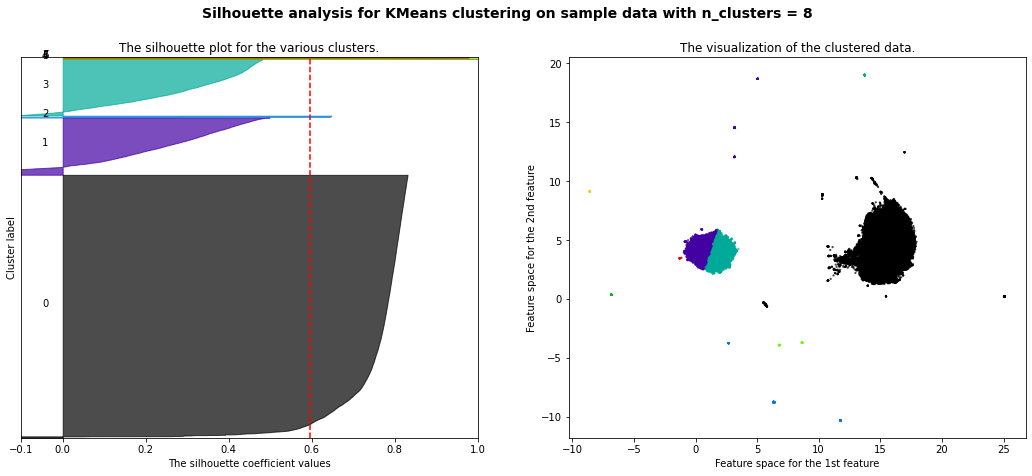

In [33]:
range_n_clusters = [2, 4, 8]

data = emb_umap

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot

    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='average')
    cluster_labels = clusterer.fit_predict(data)


    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    # using grad.rate to determine size
    ax2.scatter(data[:, 0], data[:, 1], marker='.', s=20, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

#     # Labeling the clusters
#     centers = clusterer.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [43]:
reducer = umap.UMAP(metric='cosine', n_neighbors=100) # , , min_dist=0.01
emb_umap = reducer.fit_transform(emb_norm)
emb_umap.shape

(35579, 2)

For n_clusters = 4 The average silhouette_score is : 0.84137094


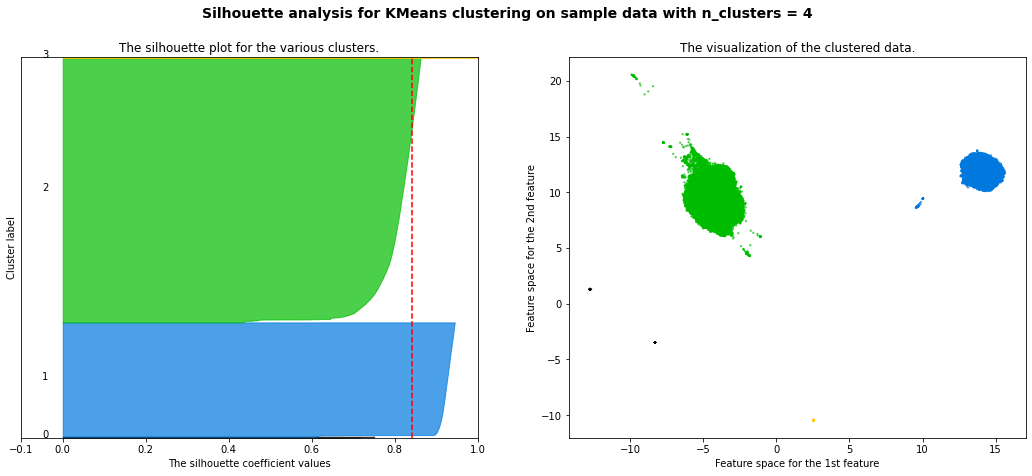

In [47]:
""" Will try to use this clustering to investigate labels """

range_n_clusters = [4]

data = emb_umap

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot

    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='average')
    cluster_labels = clusterer.fit_predict(data)


    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    # using grad.rate to determine size
    ax2.scatter(data[:, 0], data[:, 1], marker='.', s=20, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

#     # Labeling the clusters
#     centers = clusterer.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [39]:
reducer = umap.UMAP(metric='cosine', n_neighbors=200) # , , min_dist=0.01
emb_umap = reducer.fit_transform(emb_norm)
emb_umap.shape

(35579, 2)

For n_clusters = 2 The average silhouette_score is : 0.5734379
For n_clusters = 3 The average silhouette_score is : 0.8843461
For n_clusters = 4 The average silhouette_score is : 0.83980364


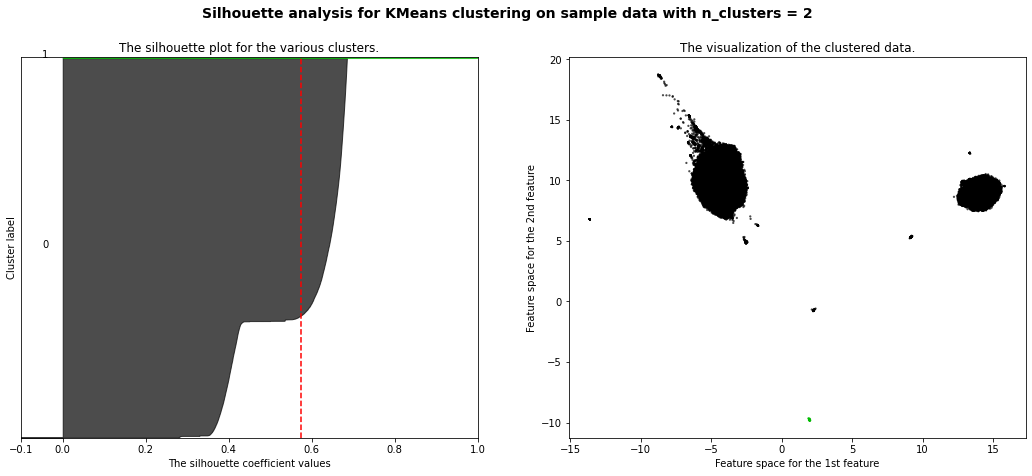

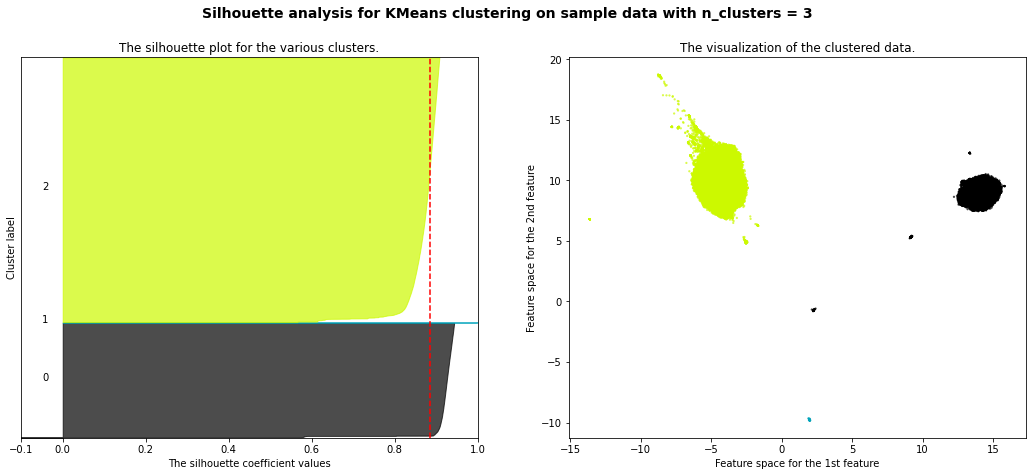

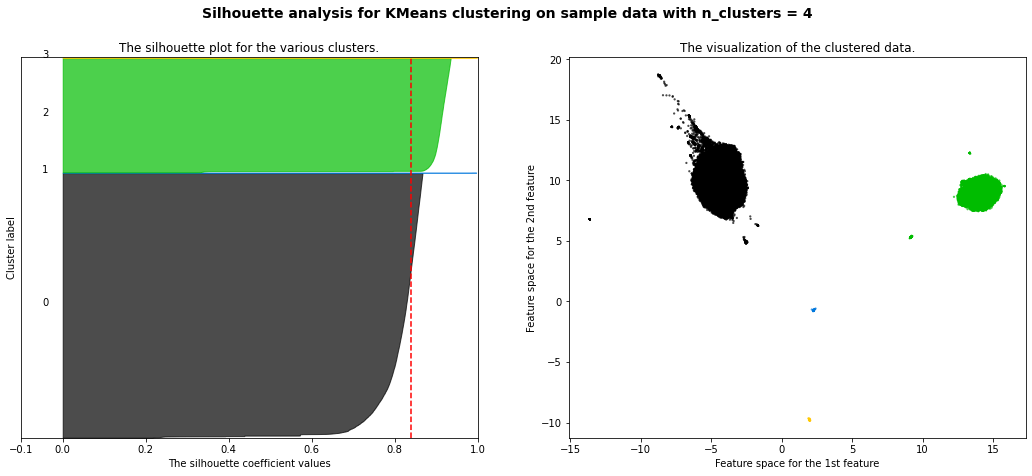

In [40]:
range_n_clusters = [2, 3, 4]

data = emb_umapb

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot

    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='average')
    cluster_labels = clusterer.fit_predict(data)


    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    # using grad.rate to determine size
    ax2.scatter(data[:, 0], data[:, 1], marker='.', s=20, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

#     # Labeling the clusters
#     centers = clusterer.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [41]:
reducer = umap.UMAP(metric='cosine', n_neighbors=200, min_dist=0.99)
emb_umap = reducer.fit_transform(emb_norm)
emb_umap.shape

(35579, 2)

For n_clusters = 2 The average silhouette_score is : 0.8064561
For n_clusters = 3 The average silhouette_score is : 0.6070818
For n_clusters = 4 The average silhouette_score is : 0.60607857


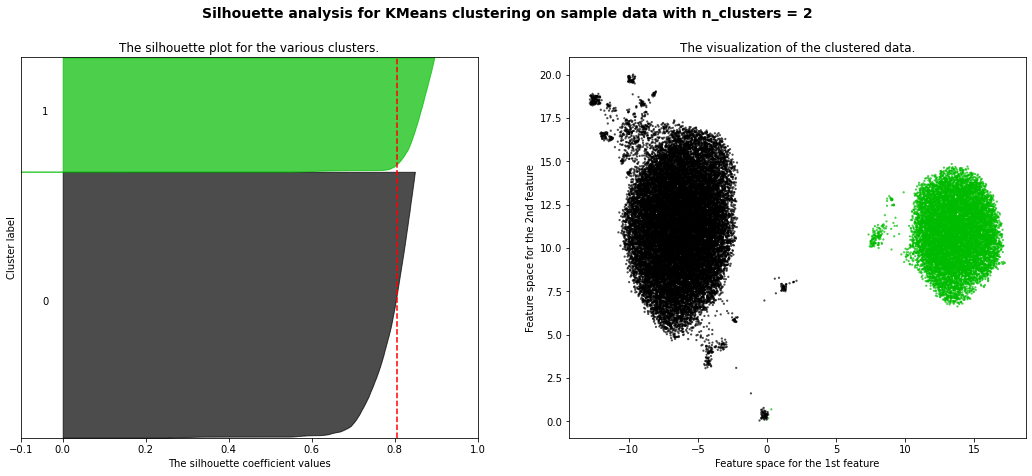

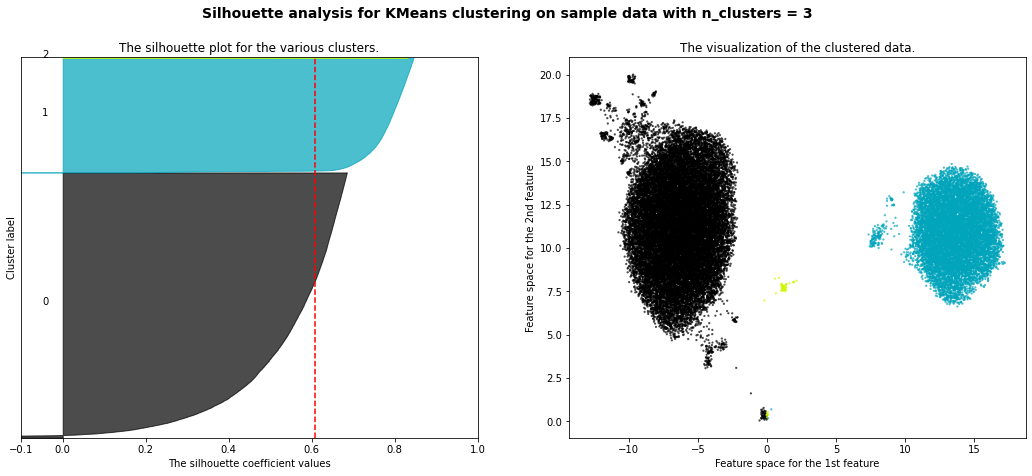

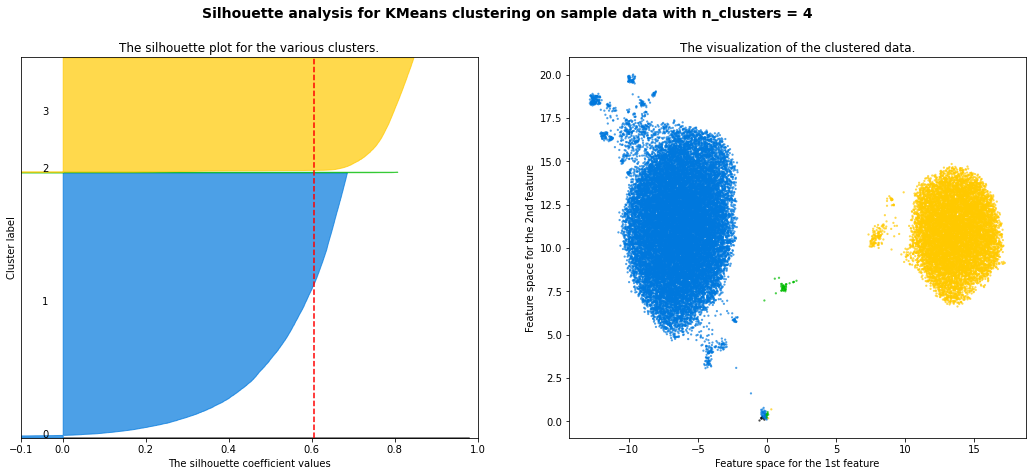

In [42]:
range_n_clusters = [2, 3, 4]

data = emb_umap

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot

    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='average')
    cluster_labels = clusterer.fit_predict(data)


    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    # using grad.rate to determine size
    ax2.scatter(data[:, 0], data[:, 1], marker='.', s=20, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

#     # Labeling the clusters
#     centers = clusterer.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [151]:
"""
df2 uses labels from one of the more coherent clusterings
"""
emb_norm2 = emb.div(emb.sum(axis=1), axis=0)
nan_idx = list(set(np.where(np.isnan(emb_norm2))[0]))
nan_idx

df2 = df.drop(labels=nan_idx, axis=0)
df2['labels'] = cluster_labels
df2['comment len'] = df['body'].apply(len)
# df2['log_score'] = np.log(df['score']+0.5)
df2

C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Unnamed: 0,body,subreddit,created_utc,score,sentiment,compound,date,labels,comment len,log_score
0,0,I don't think that the founders had any idea w...,ParlerWatch,1615758489,1,"{'neg': 0.126, 'neu': 0.779, 'pos': 0.095, 'co...",-0.9146,2021-03-14,2,1823,0.405465
1,1,and every us president since except trump.,PoliticalHumor,1615758490,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,2021-03-14,1,42,0.405465
2,2,"Trump is gone, Biden removed DFC, it is alread...",europe,1615758501,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,2021-03-14,2,53,0.405465
3,3,"No I wasn't aware of that, I'm not a Biden fan...",AskReddit,1615758513,1,"{'neg': 0.148, 'neu': 0.736, 'pos': 0.116, 'co...",-0.7231,2021-03-14,2,838,0.405465
4,4,They would not speak to trump either for the p...,worldnews,1615758515,1,"{'neg': 0.203, 'neu': 0.797, 'pos': 0.0, 'comp...",-0.6222,2021-03-14,2,95,0.405465
...,...,...,...,...,...,...,...,...,...,...,...
35577,35577,It's been going on for several months but it s...,trump,1584309542,1,"{'neg': 0.17, 'neu': 0.692, 'pos': 0.138, 'com...",-0.8343,2020-03-15,2,944,0.405465
35578,35578,Trump is my daddy.,wallstreetbets,1584309542,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,2020-03-15,2,18,0.405465
35579,35579,Fuck trump. POS,EverythingScience,1584309543,1,"{'neg': 0.636, 'neu': 0.364, 'pos': 0.0, 'comp...",-0.5423,2020-03-15,2,15,0.405465
35580,35580,&gt;It would be the official end of America as...,politics,1584309544,1,"{'neg': 0.0, 'neu': 0.78, 'pos': 0.22, 'compou...",0.7351,2020-03-15,2,141,0.405465


In [122]:
pd.DataFrame(df2.groupby(['labels'])["compound"].describe())

,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
0,92.0,0.256257,0.263391,-0.0772,0.00000,0.25235,0.5047,0.9413
1,10695.0,-0.033378,0.583831,-0.9999,-0.55855,0.00000,0.4588,0.9990
2,24731.0,-0.033791,0.611259,-0.9998,-0.59940,0.00000,0.5106,0.9995
3,61.0,0.001082,0.160049,-0.7351,0.00000,0.00000,0.0000,0.8402


In [154]:
pd.DataFrame(df2.groupby(['labels'])["score"].describe())

,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
0,86.0,0.439298,0.413248,-0.693147,0.405465,0.405465,0.405465,2.351375
1,10250.0,0.732051,0.808307,-0.693147,0.405465,0.405465,0.916291,8.371821
2,23648.0,0.690219,0.771772,-0.693147,0.405465,0.405465,0.916291,8.860996
3,57.0,0.615345,0.543452,-0.693147,0.405465,0.405465,0.405465,2.251292


In [130]:
pd.DataFrame(df2.groupby(['labels'])["comment len"].describe())

,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
0,92.0,383.173913,370.390486,10.0,10.0,442.0,762.0,1183.0
1,10695.0,380.441047,663.347516,8.0,101.0,200.0,404.0,9972.0
2,24731.0,409.622094,637.380322,8.0,111.0,224.0,463.0,10027.0
3,61.0,12.278689,22.379404,5.0,5.0,5.0,10.0,125.0


In [141]:
for i in range(4):
    print('top 10 subreddits for label group '+str(i))
    print(df2.loc[df2['labels'] == i].subreddit.value_counts()[:10])
    print('===')

top 10 subreddits for label group 0
Donald_Trump        45
politics            11
pics                 4
AskReddit            2
raimimemes           1
news                 1
doordash_drivers     1
videos               1
cringe               1
donaldtrump          1
Name: subreddit, dtype: int64
===
top 10 subreddits for label group 1
politics          2951
neoliberal         303
Conservative       297
news               295
AskReddit          273
PoliticalHumor     268
conspiracy         266
worldnews          243
PublicFreakout     172
pics               162
Name: subreddit, dtype: int64
===
top 10 subreddits for label group 2
politics          6069
worldnews          695
news               629
PoliticalHumor     613
AskReddit          599
conspiracy         582
Conservative       538
pics               495
trump              450
wallstreetbets     446
Name: subreddit, dtype: int64
===
top 10 subreddits for label group 3
AskReddit             32
wallstreetbets         3
politics      

array([[<AxesSubplot:title={'center':'compound'}>]], dtype=object)

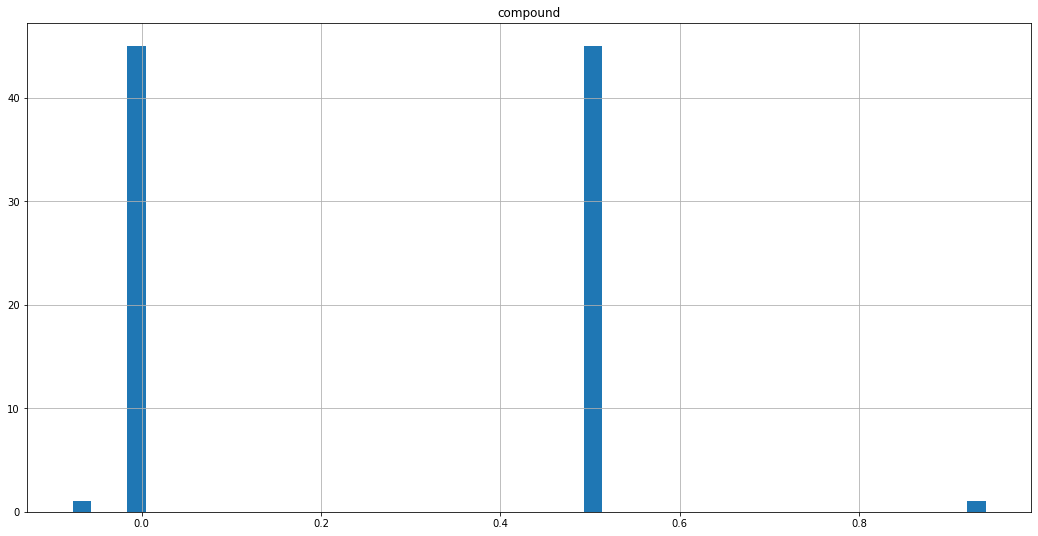

In [120]:
df2.loc[df2['labels'] == 0].hist('compound', bins=50, figsize=(18,9))

array([[<AxesSubplot:title={'center':'compound'}>]], dtype=object)

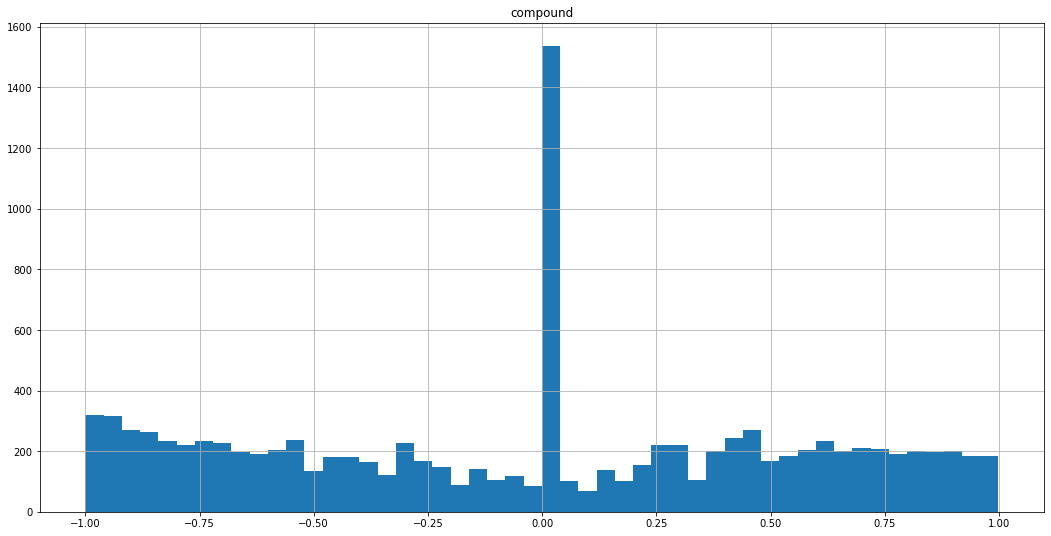

In [153]:
df2.loc[df2['labels'] == 1].hist('compound', bins=50, figsize=(18,9))

array([[<AxesSubplot:title={'center':'compound'}>]], dtype=object)

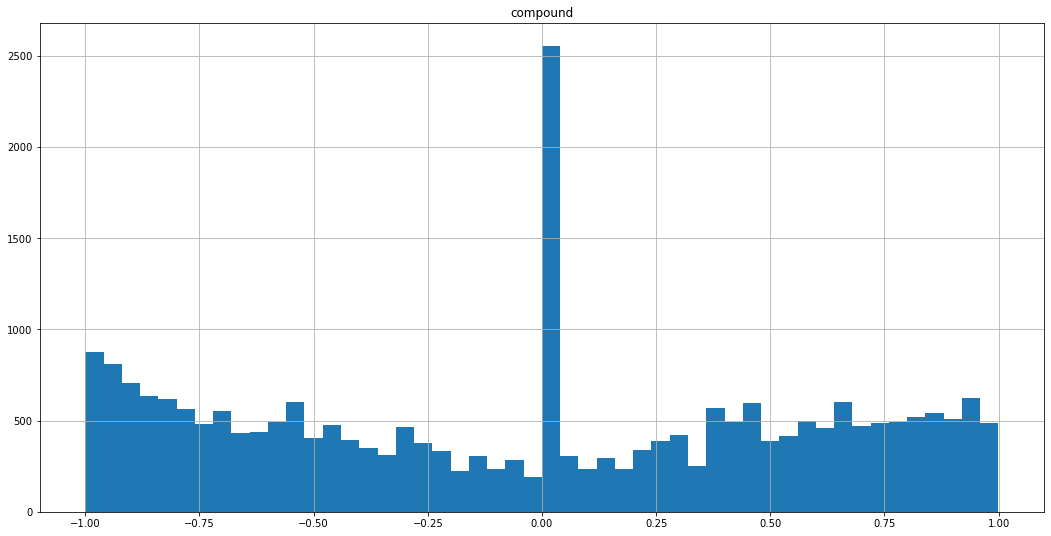

In [119]:
df2.loc[df2['labels'] == 2].hist('compound', bins=50, figsize=(18,9))

array([[<AxesSubplot:title={'center':'compound'}>]], dtype=object)

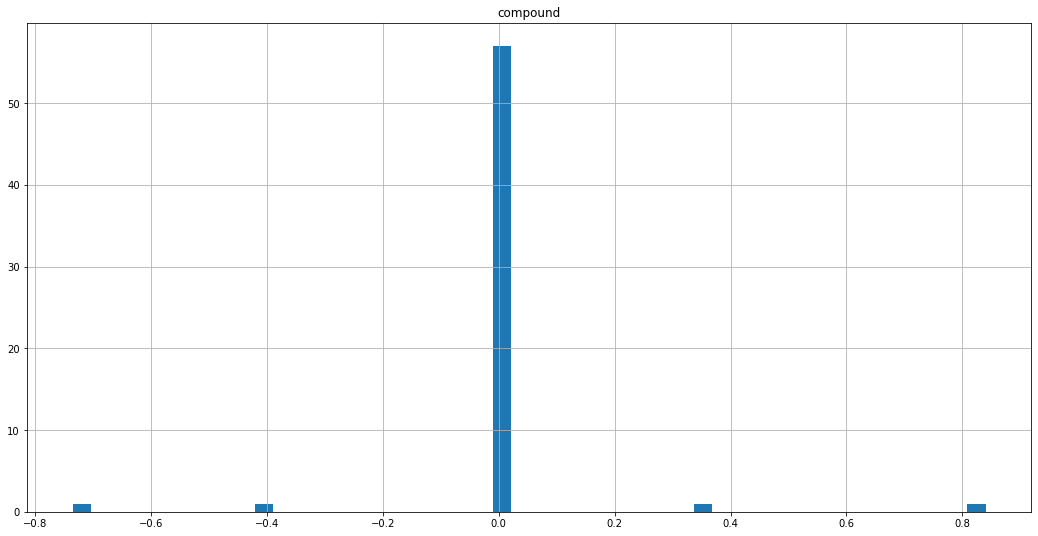

In [107]:
df2.loc[df2['labels'] == 3].hist('compound', bins=50, figsize=(18,9))